# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [156]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [157]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [158]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [159]:
df_Wine.shape

(3304, 25)

In [160]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [161]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [162]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [163]:
df_GeoCache.shape

(1228, 8)

In [164]:
df_Flag.shape

(19, 3)

In [165]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
2449,1996,48,1994,93.0,19,Robert Biale,Zinfandel Napa Valley Aldo's Vineyard,Red,Zinfandel,NaN,...,NaN,NaN,"A Zinfandel in a rich yet elegant style, showi...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1884,2002,83,1999,91.0,35,Franciscan Oakville Estate,Chardonnay Napa Valley Cuvée Sauvage,White,Chardonnay,NaN,...,2002.0,2007.0,"Rich, elegant and stylish, with pretty hazelnu...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
619,2014,18,2011,95.0,35,Château Doisy-Védrines,Barsac,Dessert & Fortified,Semillon,NaN,...,2016.0,2035.0,"Pure, with piercing persimmon, pineapple, whit...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2570,1995,69,1993,92.0,21,Stonestreet,Chardonnay Sonoma County,White,Chardonnay,NaN,...,NaN,NaN,Another remarkable Chardonnay from Stonestreet...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
225,2018,26,2015,94.0,45,Bodegas y Viñedos Valderiz,Ribera del Duero,Red,Tempranillo,NaN,...,2018.0,2030.0,"Rich and focused, this red delivers ripe fruit...",Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0
2868,1992,66,1990,88.0,28,Kumeu River,Chardonnay Kumeu,White,Chardonnay,NaN,...,NaN,NaN,"Pulls out all the stops. Ripe, buttery aromas ...",Hierarchy_00,New Zealand,New Zealand / Aotearoa,"(-41.5000831, 172.8344077, 0.0)",-41.500083,172.834408,0.0
1411,2006,10,2004,95.0,50,Two Hands,Shiraz Barossa Valley Bella's Garden,Red,Shiraz | Syrah,NaN,...,2007.0,2020.0,"Dark, deep and impressively focused, a massive...",Hierarchy_00,Australia,Australia,"(-24.7761086, 134.755, 0.0)",-24.776109,134.755000,0.0
1183,2009,82,2008,90.0,11,d'Arenberg,Shiraz McLaren Vale The Stump Jump,Red,Shiraz | Syrah,NaN,...,2009.0,2018.0,"Ripe and open-textured, this is impressive for...",Hierarchy_00,Australia,Australia,"(-24.7761086, 134.755, 0.0)",-24.776109,134.755000,0.0
1170,2009,69,2007,91.0,22,Bodega Catena Zapata,Malbec Mendoza,Red,Malbec,NaN,...,2009.0,2011.0,"A sleek, polished style, with alluring mocha a...",Hierarchy_00,Argentina,Argentina,"(-34.9964963, -64.9672817, 0.0)",-34.996496,-64.967282,0.0
3111,1989,9,1986,97.0,50,Château Pichon Longueville Lalande,Pauillac,Red,Blend,Bordeaux Blend Red,...,2000.0,NaN,Amazingly rich and elegant with concentrated a...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0


## Vintage Wines were Cases Made was Non-Zero

In [166]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [167]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0)
]

df_Wine_V.shape

(2667, 25)

In [168]:
# Average Cases Made by Wine Style - All Years
df_CM_All = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_All

,Wine_Style,Avg_Cases_Made
0,Dessert & Fortified,6854.898305
1,Red,9303.433141
2,Rosé | Rosado,12566.571429
3,Sparkling,6874.969697
4,White,12529.951589


In [169]:
# Average Cases Made by Wine Style - By Vintage Year
df_CM_ByYear = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_ByYear.sample(10)

,Vintage,Wine_Style,Avg_Cases_Made
1,1982,Red,4250.000000
123,2019,Red,88540.000000
38,1995,Red,8294.912281
28,1992,White,6034.852941
8,1986,White,2381.000000
31,1993,Sparkling,5700.000000
26,1992,Dessert & Fortified,5566.666667
103,2014,Dessert & Fortified,4000.000000
10,1987,Sparkling,2000.000000
75,2006,Red,12586.566667


### Visualization

In [170]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

Text(0.5, 1.1, 'Average Cases Made by Wine Style')

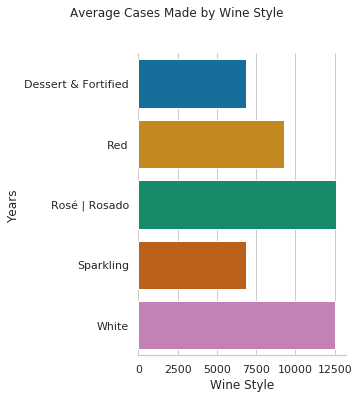

In [171]:
# bar plot of summary data

g = sns.catplot(
    data = df_CM_All,
    kind = 'bar',
    y = 'Wine_Style',
    x = 'Avg_Cases_Made'
)

g.despine(left = True)
g.set_axis_labels('Wine Style', 'Years')

plt.suptitle('Average Cases Made by Wine Style', y = 1.1)

In [172]:
# define a function to plot cases made by year by wine style

def cmby(wine_style):
    df = df_CM_ByYear[
        (df_CM_ByYear['Wine_Style'] == wine_style )
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    dim = (8, 10)
    fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Vintage',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Vintage Year', y = 1)

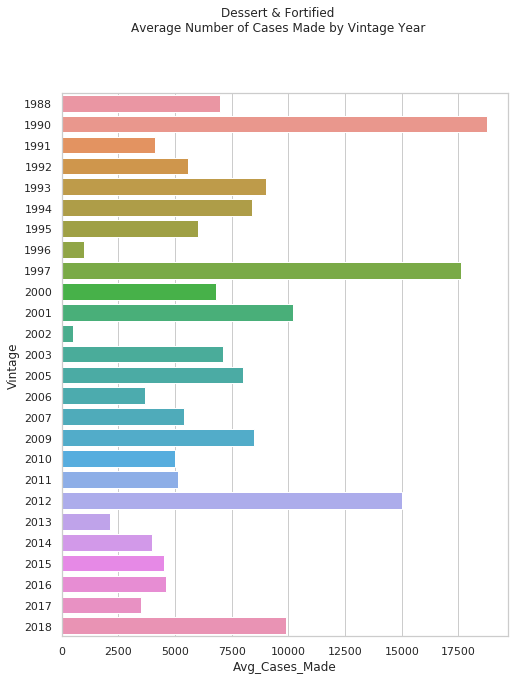

In [173]:
cmby('Dessert & Fortified')

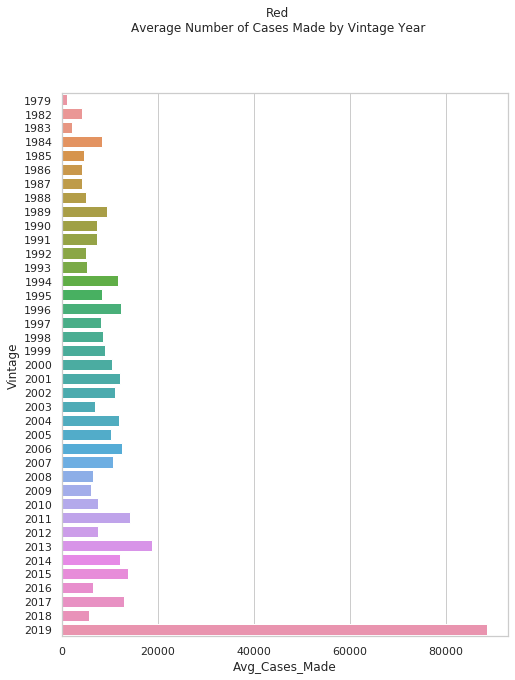

In [174]:
cmby('Red')

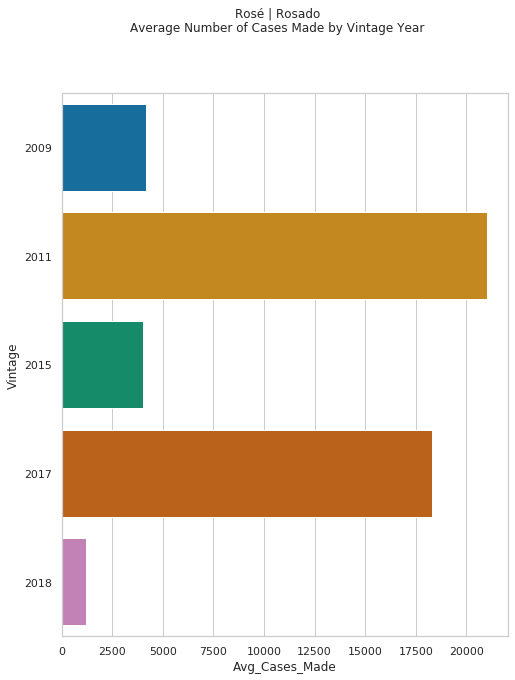

In [175]:
cmby('Rosé | Rosado')

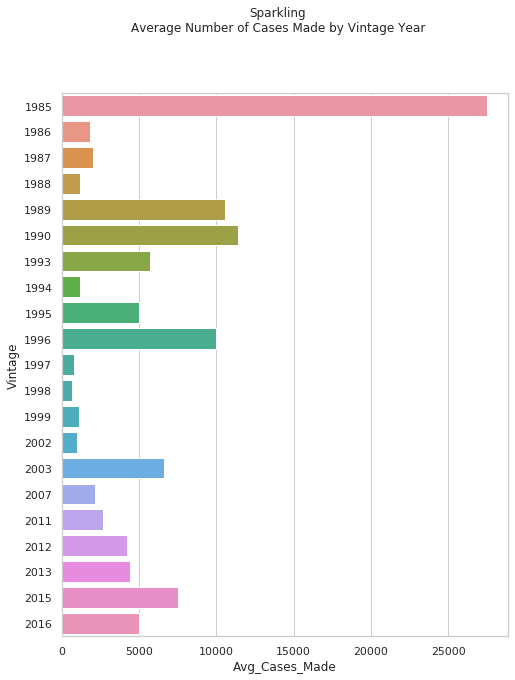

In [176]:
cmby('Sparkling')

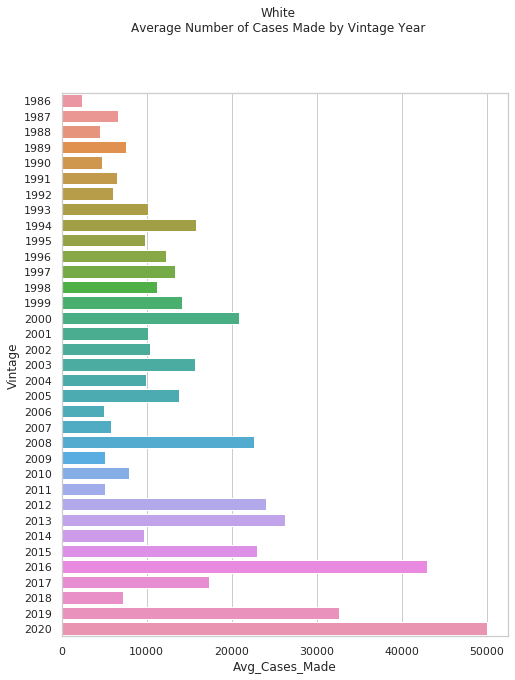

In [177]:
cmby('White')

In [178]:
# Create a dataset that allows for next-level analysis

df_CMBYBC = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style', 'Address'])['Cases_Made'].mean()})
df_CMBYBC = df_CMBYBC.reset_index()
df_CMBYBC.head()

,Vintage,Wine_Style,Address,Avg_Cases_Made
0,1979,Red,Spain,1000.0
1,1982,Red,Australia,5000.0
2,1982,Red,Spain,3500.0
3,1983,Red,Portugal,2224.0
4,1984,Red,USA,8465.0


In [179]:
# Write functions to explore specific vintage years by wine style and by country

def cmbybc(wine_style, vintage):
    df = df_CMBYBC[
        (df_CMBYBC['Wine_Style'] == wine_style ) &
        (df_CMBYBC['Vintage'] == vintage)
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    #dim = (8, 10)
    #fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Address',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Country in ' + vintage, y = 1)
    
def cmbybc_table(wine_style, vintage):
    df = df_Wine_V[
        (df_Wine_V['Wine_Style'] == wine_style ) &
        (df_Wine_V['Vintage'] == vintage)
    ]
    
    print(df[['Review_Year', 'Rank', 'Vintage', 'Score', 'Price', 'Winemaker', 'Wine', 'Wine_Style', 'Grape_Blend', 'Cases_Made', 'Cases_Imported', 'Geography', 'Address']])

In [180]:
# Explore Red wines, 2019
cmbybc_table('Red', '2019')

    Review_Year Rank Vintage  Score Price          Winemaker  \
42         2020   43    2019   90.0    13  Domaine Bousquet    

                 Wine Wine_Style Grape_Blend  Cases_Made  Cases_Imported  \
42  Malbec Tupungato         Red     Malbec      88540.0         27793.0   

    Geography    Address  
42  Tupungato  Argentina  


In [182]:
# Explore Sparkling Wines, 1985
cmbybc_table('Sparkling', '1985')

      Review_Year Rank Vintage  Score Price  Winemaker  \
3019         1990   17    1985   96.0    45  Bollinger   
3037         1990   35    1985   93.0    37     Lanson   

                             Wine Wine_Style Grape_Blend  Cases_Made  \
3019  Brut Champagne Grande Année  Sparkling   Champagne     15000.0   
3037    Brut Champagne Gold Label  Sparkling   Champagne     40000.0   

      Cases_Imported  Geography Address  
3019             0.0  Champagne  France  
3037             0.0  Champagne  France  


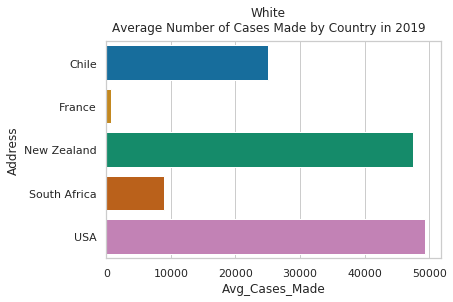

In [183]:
# Explore White Wines, 2019
cmbybc('White', '2019')

In [155]:
# Explore White Wines, 2019
cmbybc_table('White', '2019')

    Review_Year Rank Vintage  Score Price        Winemaker  \
20         2020   21    2019   92.0    12       Joel Gott    
49         2020   50    2019   90.0    14      Los Vascos    
58         2020   59    2019   90.0    16  Southern Right    
65         2020   66    2019   90.0    20           Invivo   
72         2020   73    2019   90.0    20      Spy Valley    
83         2020   84    2019   94.0    35           Delas    
93         2020   94    2019   90.0    15   Klinker Brick    

                                                 Wine Wine_Style  \
20                        Sauvignon Blanc California       White   
49                 Sauvignon Blanc Casablanca Valley       White   
58                        Sauvignon Blanc Walker Bay       White   
65  Sauvignon Blanc Marlborough X, Sarah Jessica P...      White   
72                       Sauvignon Blanc Marlborough       White   
83                     St.-Joseph White Les Challeys       White   
93                         

In [185]:
# Explore White Wines, 2020
cmbybc_table('White', '2020')

    Review_Year Rank Vintage  Score Price     Winemaker  \
22         2020   23    2020   92.0    17  Allan Scott    

                            Wine Wine_Style      Grape_Blend  Cases_Made  \
22  Sauvignon Blanc Marlborough       White  Sauvignon Blanc     50000.0   

    Cases_Imported    Geography      Address  
22         16000.0  Marlborough  New Zealand  


## Vintage Wines were Cases Made and Cases Imported were Non-Zero

In [187]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_VC = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0) &
    (df_Wine.Cases_Imported != 0)
]

df_Wine_VC.shape

(92, 25)

In [188]:
# Calculate Cases Imported as percentage of Cases Made

df_Wine_VC['Case_Ratio'] = df_Wine_VC['Cases_Imported'] / df_Wine_VC['Cases_Made']

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [189]:
df_Wine_VC.head()

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude,Case_Ratio
0,2020,1,2010,96.0,139,Bodegas Marqués de Murrieta,Rioja Castillo Ygay Gran Reserva Especial,Red,Blend,Tempranillo and Mazuelo.,...,2030.0,"Maturing well, this round red is a lovely exam...",Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0,0.090667
2,2020,3,2015,97.0,90,San Filippo,Brunello di Montalcino Le Lucére,Red,Brunello di Montalcino,0,...,2043.0,"Effusive aromas of black currant, blueberry, v...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.500000
4,2020,5,2016,96.0,90,Domaine de la Vieille Julienne,Châteauneuf-du-Pape Les Trois Sources,Red,Châteauneuf-du-Pape,0,...,2040.0,"A lush, ripe style, with açaí berry, blueberry...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0,0.250000
6,2020,7,2016,95.0,53,Massolino,Barolo,Red,Blend,Nebbiolo,...,2045.0,"A stream of pure, juicy cherry fruit is at the...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.362069
10,2020,11,2016,97.0,40,Castello di Volpaia,Chianti Classico Riserva,Red,Chianti,0,...,2040.0,"Enticing aromas of black cherry, black currant...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.550000


In [190]:
# Average by Vintage Year
df_CRBY = pd.DataFrame({'Case_Ratio' : df_Wine_VC.groupby(['Vintage'])['Case_Ratio'].mean()}).reset_index()
df_CRBY.head()

,Vintage,Case_Ratio
0,2010,0.090667
1,2013,0.400000
2,2015,0.319173
3,2016,0.292710
4,2017,0.364699


Text(0.5, 1, 'Average Cases Imported as Percentage of Cases Made')

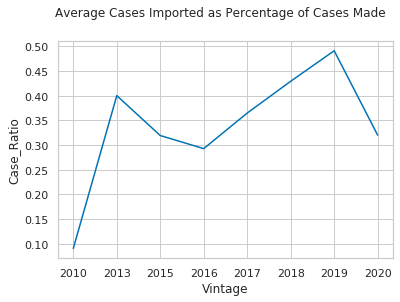

In [193]:
# Graph Case Ratio by Vintage Year

sns.lineplot(data = df_CRBY, x = 'Vintage', y = 'Case_Ratio')
plt.suptitle('Average Cases Imported as Percentage of Cases Made', y = 1)